# Calculate first latency pdf- probability density function of the time to first opening

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as nplin
import math

In [2]:
from scalcs.samples import samples
from scalcs import scalcslib as scl
from scalcs import qmatlib as qm
from scalcs import mechanism
from scalcs import pdfs

##### Load Colquhoun, Hawkes, Merlushkin & Edmonds 1997 numerical example

In [3]:
def CHME97():
    
    mectitle = 'CHME97'
    ratetitle = 'CHME97 numerical example'

    A2RS = mechanism.State('A', 'A2R*', 60e-12)
    A2D  = mechanism.State('B', 'A2D', 0.0)
    A2R  = mechanism.State('B', 'A2R', 0.0)
    AR   = mechanism.State('C', 'AR', 0.0)
    R    = mechanism.State('C', 'R', 0.0)

    RateList = [
         
         mechanism.Rate(916.0, A2RS, A2R, name='alpha', limits=[1e-15,1e+7]),
         mechanism.Rate(46.5, A2R, A2RS, name='beta', limits=[1e-15,1e+7]),
         mechanism.Rate(1.8, A2D, A2R, name='k-D', limits=[1e-15,1e+7]),
         mechanism.Rate(8.4, A2R, A2D, name='k+D', limits=[1e-15,1e+7]),
         
         mechanism.Rate(5.0e06, AR, A2R, name='k(+2)', eff='c', limits=[1e-15,1e+10]),
         mechanism.Rate(2 * 4.7, A2R, AR, name='2k(-2)', limits=[1e-15,1e+7]),
         mechanism.Rate(2 * 5.0e06, R, AR, name='2k(+1)', eff='c', limits=[1e-15,1e+10]),
         mechanism.Rate(4.7, AR, R, name='k(-1)', limits=[1e-15,1e+10])
         ]
    
    CycleList = []

    return  mechanism.Mechanism(RateList, CycleList, mtitle=mectitle, rtitle=ratetitle) #, fastblk, KBlk)

In [4]:
c0 = 0.0 # 0 mM
c1 = 0.001 # 1 mM
mec0 = CHME97()
mec0.set_eff('c', c0)
mec1 = CHME97()
mec1.set_eff('c', c1)

##### Define few functions (slightly modified from those already existing in scalcs.scalcslib; TODO: update scalcslib to make existing functions more general)

In [5]:
def asymptotic_areas_first_latency(tres, roots, pinf, mec): 
    """
    Find the areas of the asymptotic pdf.

    Parameters
    ----------
    tres : float
        Time resolution (dead time).
    roots : array_like, shape (1,kF)
        Roots of the asymptotic pdf.
    pinf : ndarray, shape (1, kF)
    mec :

    Returns
    -------
    areas : ndarray, shape (1, kA)
    """

    R = qm.AR(roots, tres, mec.QFF, mec.QAA, mec.QFA, mec.QAF, mec.kF, mec.kA)
    uA = np.ones((mec.kA,1))
    areas = np.zeros(mec.kF)
    for i in range(mec.kF):
        areas[i] = ((-1 / roots[i]) *
            np.dot(pinf, np.dot(np.dot(R[i], np.dot(mec.QFA, qm.expQt(mec.QAA, tres))), uA)))
    return areas

def asymptotic_pdf(t, tres, tau, area):
    """
    Calculate asymptotic probabolity density function.

    Parameters
    ----------
    t : ndarray.
        Time.
    tres : float
        Time resolution.
    tau : ndarray, shape(k, 1)
        Time constants.
    area : ndarray, shape(k, 1)
        Component relative area.

    Returns
    -------
    apdf : ndarray.
    """
    t1 = np.extract(t[:] < tres, t)
    t2 = np.extract(t[:] >= tres, t)
    apdf2 = pdfs.expPDF(t2 - tres, tau, area)
    apdf = np.append(t1 * 0.0, apdf2)

    return apdf

def exact_GAMAxx(tres, phi, mec):
    """
    Calculate gama coeficients for the exact pdf.

    Parameters
    ----------
    tres : float
    pinf :
    mec : dcpyps.Mechanism
        The mechanism to be analysed.

    Returns
    -------
    eigen : ndarray, shape (k,)
        Eigenvalues of -Q matrix.
    gama00, gama10, gama11 : ndarrays
        Constants for the exact open/shut time pdf.
    """

    expQAA = qm.expQt(mec.QAA, tres)
    eigs, A = qm.eigs_sorted(-mec.Q)

    eigen, Z00, Z10, Z11 = qm.Zxx(mec.Q, eigs, A, mec.kA,
        mec.QAA, mec.QFA, mec.QAF, expQAA, False)
    u = np.ones((mec.kA, 1))

    gama00 = (np.dot(np.dot(phi, Z00), u)).T[0]
    gama10 = (np.dot(np.dot(phi, Z10), u)).T[0]
    gama11 = (np.dot(np.dot(phi, Z11), u)).T[0]

    return eigen, gama00, gama10, gama11

#### The special case of a simple step from zero concentration

In [6]:
points = 512
tstart = 1.0e-6 
tend = 0.1
tseq = np.logspace(math.log10(tstart), math.log10(tend), points)

In [7]:
tres = 0.0007 # 0.7 ms
phiF0 = qm.pinf(mec0.Q)[mec0.kA:]

In [8]:
# Ideal pdf: alculate using spectral matrices
eigs, w = scl.ideal_dwell_time_pdf_components(mec1.QFF, phiF0)
ipdf = pdfs.expPDF(tseq, 1 / eigs, w / eigs) 

In [9]:
# Asymptotic pdf
roots = scl.asymptotic_roots(tres, mec1.QFF, mec1.QAA, mec1.QFA, mec1.QAF,
        mec1.kF, mec1.kA)
areas = asymptotic_areas_first_latency(tres, roots, phiF0, mec1)
apdf = asymptotic_pdf(tseq, tres, -1 / roots, areas)

In [10]:
# Exact pdf
eigvals, gamma00, gamma10, gamma11 = exact_GAMAxx(tres, phiF0, mec1) #tres, pinf, mec
epdf = np.zeros(points)
for i in range(points):
    epdf[i] = (scl.exact_pdf(tseq[i], tres,
        roots, areas, eigvals, gamma00, gamma10, gamma11))

red dashed- ideal pdf; blue dashed- asymptotic pdf; blue solid- exact + asymptotic pdf


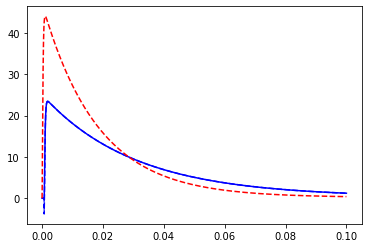

In [11]:
plt.plot(tseq, apdf, 'b--');
plt.plot(tseq, epdf, 'b-');
plt.plot(tseq, ipdf, 'r--');
print('red dashed- ideal pdf; blue dashed- asymptotic pdf; blue solid- exact + asymptotic pdf')

red dashed- ideal pdf; blue dashed- asymptotic pdf; blue solid- exact + asymptotic pdf


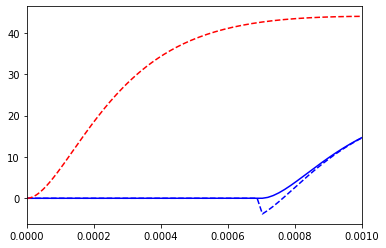

In [12]:
plt.plot(tseq, apdf, 'b--');
plt.plot(tseq, epdf, 'b-');
plt.plot(tseq, ipdf, 'r--');
plt.xlim([0.0, 0.001]);
print('red dashed- ideal pdf; blue dashed- asymptotic pdf; blue solid- exact + asymptotic pdf')